# NGC 4848

NGC 4848 (CGCG 160-055; Zwicky et al. 1961−1968) is
a bright (MB = −20.5) SBab:edge-on (RC3, de Vaucouleurs
et al. 1991) galaxy that lies at the northwest (N-W) periphery of
the X-ray emitting region in the Coma cluster. It has a vigorous star-formation rate (SFR) of ∼9 $M_\odot\, \text{yr}^{−1}$ as derived from the Hα, ultraviolet (UV), far-infrared (FIR), and radio-continuum emission.

In spite of its SBab classification, the morphology of NGC 4848
is rather irregular, being composed of a central nuclear source
(harboring an active galactic nucleus (AGN) [NII]λ6584 Å/Hα =
0.64, see Gavazzi et al. 2011) with red (g − i = 1.5 mag) color.
At a 5−10 arcsec projected radial distance from the nucleus, a
bright, blue, and clumpy ring of active HII regions dominates
the galaxy morphology. Further out, the light profile falls-oﬀ ex-
ponentially, as is typical of a disk

<img src="images/NGC4848.png" width="500"/>

# MUSE

In [133]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt

# Open the FITS file and load data
with fits.open("DATA/NGC_4848/NGC4848_cut.fits") as hdul:
    hdul.info() 
    
    print('\n')
    header = hdul[1].header
    for card in header.cards:
        print(f"{card[0]:<8} = {card[1]} / {card[2]}")

    # Load data
    cube = hdul[1].data 
    var = hdul[2].data 

# Generate the wavelength array
crval3 = header['CRVAL3']
dw = header['CD3_3'] 
channels = np.arange(0, header['NAXIS3'], 1)
w = header['CRVAL3'] + channels * header['CD3_3']  # Wavelength in Angstrom

# Define unit conversions
cube_units = 1e-20 
var_units = cube_units**2  # Ensure consistency instead of hardcoding 1e-40

# Extract WCS parameters from the header
wcs = WCS(header)

# Extract image dimensions
naxis1, naxis2 = header['NAXIS1'], header['NAXIS2']

# Compute RA/Dec limits from pixel indices (setting spectral axis to 0)
ra_min, dec_min, _ = wcs.all_pix2world([[0, 0, 0]], 0)[0]       # Bottom-left corner
ra_max, dec_max, _ = wcs.all_pix2world([[naxis1, naxis2, 0]], 0)[0]  # Top-right corner



Filename: DATA/NGC_4848/NGC4848_cut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   ()      
  1  DATA          1 ImageHDU        40   (290, 395, 3400)   float32   
  2  STAT          1 ImageHDU        40   (290, 395, 3400)   float32   


XTENSION = IMAGE / Image extension
BITPIX   = -32 / array data type
NAXIS    = 3 / number of array dimensions
NAXIS1   = 290 / 
NAXIS2   = 395 / 
NAXIS3   = 3400 / 
PCOUNT   = 0 / number of parameters
GCOUNT   = 1 / number of groups
WCSAXES  = 3 / Number of coordinate axes
CRPIX1   = 140.90387017484 / Pixel coordinate of reference point
CRPIX2   = 113.36084811896 / Pixel coordinate of reference point
CUNIT1   = deg / Units of coordinate increment and value
CUNIT2   = deg / Units of coordinate increment and value
CTYPE1   = RA---TAN / Right ascension, gnomonic projection
CTYPE2   = DEC--TAN / Declination, gnomonic projection
CRVAL1   = 194.5234088 / [deg] Coordinate value at reference point
C

In [134]:
print(ra_min,ra_max)
print(dec_min,dec_max)

194.53223072835175 194.51394223048234
28.232401597627494 28.25434599860988


In [135]:
# spectra adding all spatial pixels

summed_spectra = np.nansum(cube, axis=(1, 2))
summed_var = np.nansum(var, axis=(1,2))

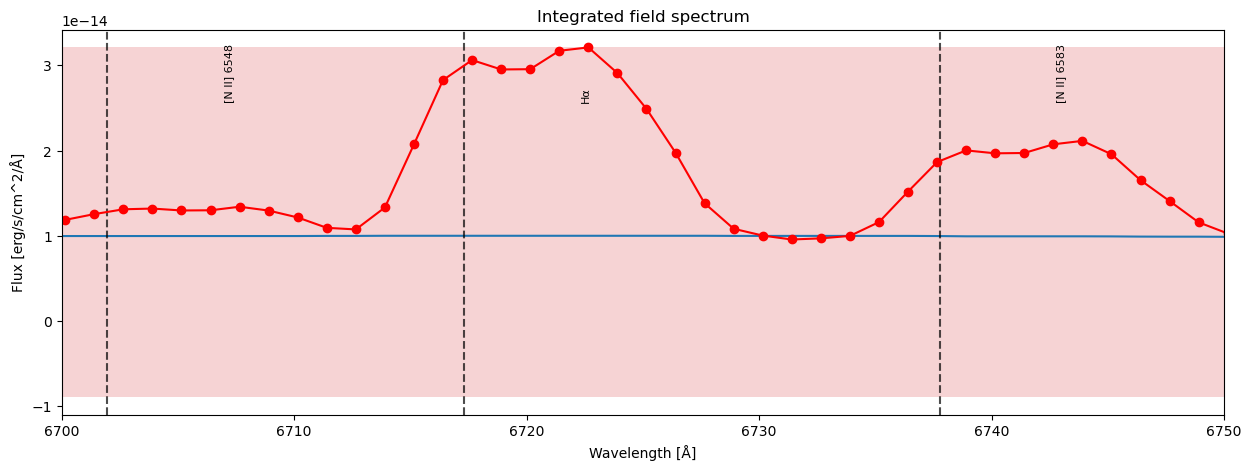

In [146]:
fig,ax = plt.subplots(figsize=(15,5))
plt.title("Integrated field spectrum")

plt.errorbar(w, summed_spectra*cube_units, yerr=np.sqrt(summed_var*var_units), fmt='o', color='red', ecolor='green', elinewidth=1.5, capsize=3, capthick=1.5,linestyle='-')

from scipy.ndimage import median_filter
continuum = median_filter(summed_spectra, size=101,mode="nearest")  # Choose an odd kernel size
plt.plot(w,continuum*cube_units)

plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [erg/s/cm^2/Å]")

# Define UBVRI filter wavelength ranges (in Angstrom)
filters = {
    "U": (3200, 4000),
    "B": (4000, 5000),
    "V": (5000, 6000),
    "R": (6000, 7000),
    "I": (7000, 9000),
}

min = np.min(summed_spectra*cube_units)
max = np.max(summed_spectra*cube_units)
# Add vertical shaded regions corresponding to the filters
for name, (wmin, wmax) in filters.items():
    plt.fill_betweenx([min, max], wmin, wmax, alpha=0.2, label=f"{name} filter")
    
z =  0.023513

# Define important emission/absorption lines in galaxies
# Define important emission/absorption lines in galaxies
spectral_lines = {
    # Optical Lines
    "O II (Doublet)": 3727,
    "Hγ": 4340,
    "Hδ": 4102,
    "Hβ": 4861,
    "[O III] 4959": 4959,
    "[O III] 5007": 5007,
    "He II 4686": 4686,
    "He I 4471": 4471,
    "He I 5876": 5876,
    "Hα": 6563,
    "[N II] 6548": 6548,
    "[N II] 6583": 6583,
    "[S II] 6716": 6716,
    "[S II] 6731": 6731,
    "[Ar III] 7136": 7136,
    "[Fe II] 5159": 5159,

    # Calcium Lines
    "[Ca II] 8498": 8498,
    "[Ca II] 8542": 8542,
    "[Ca II] 8662": 8662,
    "Ca H": 3968,
    "Ca K": 3934,

    # Magnesium and Sodium Lines
    "Mg I 5175": 5175,
    "Na I D (Doublet)": 5890,  # Doublet at 5890 and 5896 Å
}
# Apply redshift correction to each spectral line
redshifted_lines = {name: wavelength * (1 + z) for name, wavelength in spectral_lines.items()}

# Add vertical dashed lines for spectral features
for name, wavelength in redshifted_lines.items():
    plt.axvline(wavelength, color="black", linestyle="dashed", alpha=0.7)
    plt.text(wavelength + 5, max * 0.8, name, 
             rotation=90, verticalalignment="bottom", fontsize=8, zorder=1, clip_on=True)

#plt.xlim(4750.15,7500)
plt.xlim(6700,6750)
#plt.xlim(6000,7000)



plt.show()


In [137]:
# Define Ha flux map and continuum flux map

Ha_channel_inf = int((6700 - crval3)/dw)
Ha_channel_sup = int((6750 - crval3)/dw)
continuum_channel_inf = int((6645 - crval3)/dw)
continuum_channel_sup = int((6695 - crval3)/dw)

bandwidth = 50 # angstrom
dtheta_pix = abs(header['CD1_1'])

units = 1e-20 * bandwidth / ( dtheta_pix* 3600 )**2   # integrating on wavelength, per arcsec^2

integrated_Ha_continuum = np.nansum(cube[Ha_channel_inf:Ha_channel_sup, :, :],axis=0) * units
integrated_continuum_near_Ha = np.nansum(cube[continuum_channel_inf:continuum_channel_sup, :, :], axis=0) * units

integrated_Ha = integrated_Ha_continuum - integrated_continuum_near_Ha


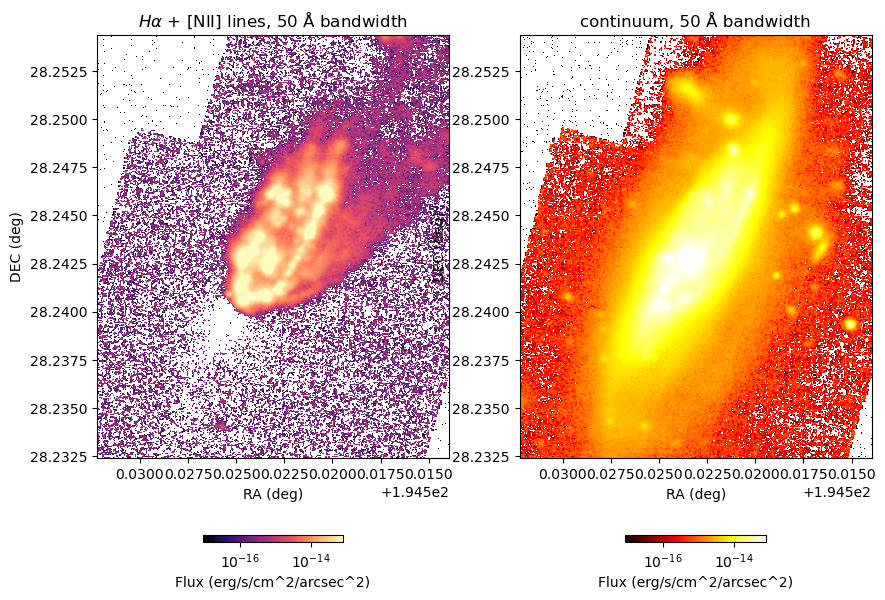

In [147]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 2, figsize=(10, 10))  # Adjust the size for better appearance
ax = ax.flatten()

# Define color normalization for logarithmic scaling
norm = LogNorm(np.nanquantile(integrated_Ha[integrated_Ha>0], 0.01), vmax=np.nanquantile(integrated_Ha, 0.99))

# Plotting the integrated Ha
cmap = plt.cm.magma
cmap.set_bad(color='white')
im0 = ax[0].imshow(integrated_Ha, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap=cmap, norm=norm)
ax[0].set_title("$H\\alpha$ + [NII] lines, 50 Å bandwidth")
ax[0].set_xlabel("RA (deg)")  
ax[0].set_ylabel("DEC (deg)")  

# Plotting the integrated continuum near Ha
im1 = ax[1].imshow(integrated_continuum_near_Ha, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap='hot', norm=norm)
ax[1].set_title("continuum, 50 Å bandwidth")
ax[1].set_xlabel("RA (deg)")  
ax[1].set_ylabel("DEC (deg)")  

cbar0 = fig.colorbar(im0, ax=ax[0], location='bottom', shrink=0.4, pad = 0.1)
cbar1 = fig.colorbar(im1, ax=ax[1], location='bottom', shrink=0.4, pad = 0.1)

cbar0.set_label("Flux (erg/s/cm^2/arcsec^2)")  
cbar1.set_label("Flux (erg/s/cm^2/arcsec^2)")  

In [140]:
# Create regions
import matplotlib.path as mpath

# Ellipse parameters
center = (194.523241, 28.242570)  # Center of the galaxy (reference coordinates)
angle = - 64  # Angle of tilt in degrees

x = np.linspace(ra_min,ra_max)
m_semimajor_axis = np.tan(np.radians(angle))
y_semi =  m_semimajor_axis * (x - center[0]) + center[1]

e = np.sqrt(1-(160/450)**2)
width = 0.0015 #30 * cdelt1
n = 7

# Generate the coordinate grid
y_coords, x_coords = np.meshgrid(np.linspace(dec_min, dec_max, integrated_Ha.shape[0]),
                                 np.linspace(ra_min, ra_max, integrated_Ha.shape[1]),
                                 indexing='ij')
x_p = 194.52 + 0.0046
y_p = m_semimajor_axis * (x_p - center[0]) + center[1]
m_line = -1/m_semimajor_axis
y_line =  m_line * (x - x_p) + y_p

down_mask = (y_coords < m_line * (x_coords - x_p) + y_p)



points = np.vstack((x_coords.ravel(), y_coords.ravel())).T

masks = []

for i in range(1, n):

    mask = np.zeros_like(integrated_Ha, dtype=bool)
    
    # external ellipse
    a = width * i                # semimajor axis
    b = a * np.sqrt(1-e**2)   

    # Generate ellipse vertices
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_x = a * np.cos(theta)
    ellipse_y = b * np.sin(theta)
    cos_angle, sin_angle = np.cos(np.radians(angle)), np.sin(np.radians(angle))
    x_rot = ellipse_x * cos_angle - ellipse_y * sin_angle
    y_rot = ellipse_x * sin_angle + ellipse_y * cos_angle
    vertices_ext = np.column_stack([x_rot + center[0], y_rot + center[1]])

    # internal ellipse
    a = width * (i-1)                # semimajor axis
    b = a * np.sqrt(1-e**2)   

    # Generate ellipse vertices
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_x = a * np.cos(theta)
    ellipse_y = b * np.sin(theta)
    cos_angle, sin_angle = np.cos(np.radians(angle)), np.sin(np.radians(angle))
    x_rot = ellipse_x * cos_angle - ellipse_y * sin_angle
    y_rot = ellipse_x * sin_angle + ellipse_y * cos_angle
    vertices_int = np.column_stack([x_rot + center[0], y_rot + center[1]])

    # Create paths for the ellipses
    path_ext = mpath.Path(vertices_ext)
    path_int = mpath.Path(vertices_int)

    # Mask points within the external but outside the internal ellipse
    mask_ext = path_ext.contains_points(points).reshape(mask.shape)
    mask_int = path_int.contains_points(points).reshape(mask.shape)
    
    mask |= (mask_ext & ~mask_int & down_mask)
    
    if len(mask[mask==True])>0:
        masks.append(mask)
    

In [141]:
# Saves regions in a format good for ds9

# DS9 header in FK5 system (RA/Dec)
header = """# Region file format: DS9 version 4.1
global color=green dashlist=8 3 width=1 font="helvetica 10 normal" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1
fk5
"""


filename = "DATA/NGC_4848/regions_fk5.reg"

# Define the mapping from pixel to world coordinates
pixel_x_range = np.arange(integrated_Ha.shape[1])  # Pixel range along x-axis
pixel_y_range = np.arange(integrated_Ha.shape[0])  # Pixel range along y-axis
ra_range = np.linspace(ra_min, ra_max, integrated_Ha.shape[1])  # RA range
dec_range = np.linspace(dec_min, dec_max, integrated_Ha.shape[0])  # Dec range

with open(filename, "w") as f:
    f.write(header)

    for mask in masks:
        contours = find_contours(mask, level=0.5)  # Extract mask boundaries

        for contour in contours:
            # Convert pixel (x, y) to (RA, Dec)
            ra_vals = np.interp(contour[:, 1], pixel_x_range, ra_range)
            dec_vals = np.interp(contour[:, 0], pixel_y_range, dec_range)

            # Format contour points as a DS9 polygon
            points = ", ".join(f"{ra:.6f},{dec:.6f}" for ra, dec in zip(ra_vals, dec_vals))
            f.write(f"polygon({points})\n")

print(f"DS9 FK5 region file saved: {filename}")



DS9 FK5 region file saved: DATA/NGC_4848/regions_fk5.reg


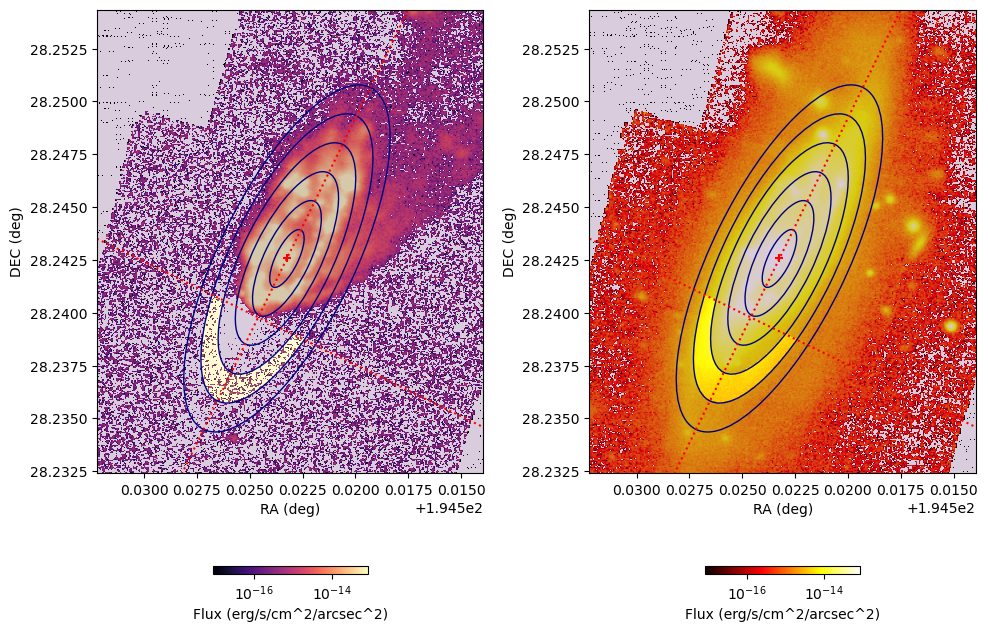

In [142]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 2, figsize=(10, 10))  # Adjust the size for better appearance
ax = ax.flatten()

# Define color normalization for logarithmic scaling
norm = LogNorm(np.nanquantile(integrated_Ha[integrated_Ha>0], 0.01), vmax=np.nanquantile(integrated_Ha, 0.99))

# Plotting the integrated Ha
cmap = plt.cm.magma
cmap.set_bad(color='white')
im0 = ax[0].imshow(integrated_Ha, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap=cmap, norm=norm)
ax[0].set_xlabel("RA (deg)")  # Label for X-axis
ax[0].set_ylabel("DEC (deg)")  # Label for Y-axis

# Plotting the integrated continuum near Ha
im1 = ax[1].imshow(integrated_continuum_near_Ha, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap='hot', norm=norm)
ax[1].set_xlabel("RA (deg)")  # Label for X-axis
ax[1].set_ylabel("DEC (deg)")  # Label for Y-axis

cbar0 = fig.colorbar(im0, ax=ax[0], location='bottom', shrink=0.4, pad = 0.1)
cbar1 = fig.colorbar(im1, ax=ax[1], location='bottom', shrink=0.4, pad = 0.1)

cbar0.set_label("Flux (erg/s/cm^2/arcsec^2)")  
cbar1.set_label("Flux (erg/s/cm^2/arcsec^2)")  

# Create ellipses and add them to the plot
for i in range(1, n):
    a = width * i                # semimajor axis
    b = a * np.sqrt(1-e**2)   
    
    for k in range(2):
        ellipse = Ellipse(center, a*2, b*2, angle=angle, edgecolor='navy', facecolor='none')
        ax[k].add_patch(ellipse)
        #x_text = center[0] + a * np.cos(np.radians(angle)) - 5
        #y_text = m_semimajor_axis * (x_text - center[0]) + center[1]
        #ax[k].text(x_text,y_text, i, fontsize=15, zorder=1, clip_on=True,c='navy')

ax[0].scatter(center[0], center[1], marker='+', c='red')
ax[1].scatter(center[0], center[1], marker='+', c='red')
ax[0].plot(x,y_semi,linestyle=':',c='red')
ax[1].plot(x,y_semi,linestyle=':',c='red')
ax[0].plot(x,y_line,linestyle=':',c='red')
ax[1].plot(x,y_line,linestyle=':',c='red')

ax[0].imshow(masks[2], extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', interpolation='none', alpha=0.2) 
ax[1].imshow(masks[2], extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', interpolation='none', alpha=0.2) 

for k in range(2):
    ax[k].set_xlim(ra_min,ra_max)
    ax[k].set_ylim(dec_min,dec_max)
    #ax[k].set_xlim(194.5+0.03,194.5+0.022)
    #ax[k].set_ylim(28.235,28.243)
    #ax[k].grid()


# Adjusting layout to make it fit better
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the tight_layout to leave space for colorbars
plt.show()


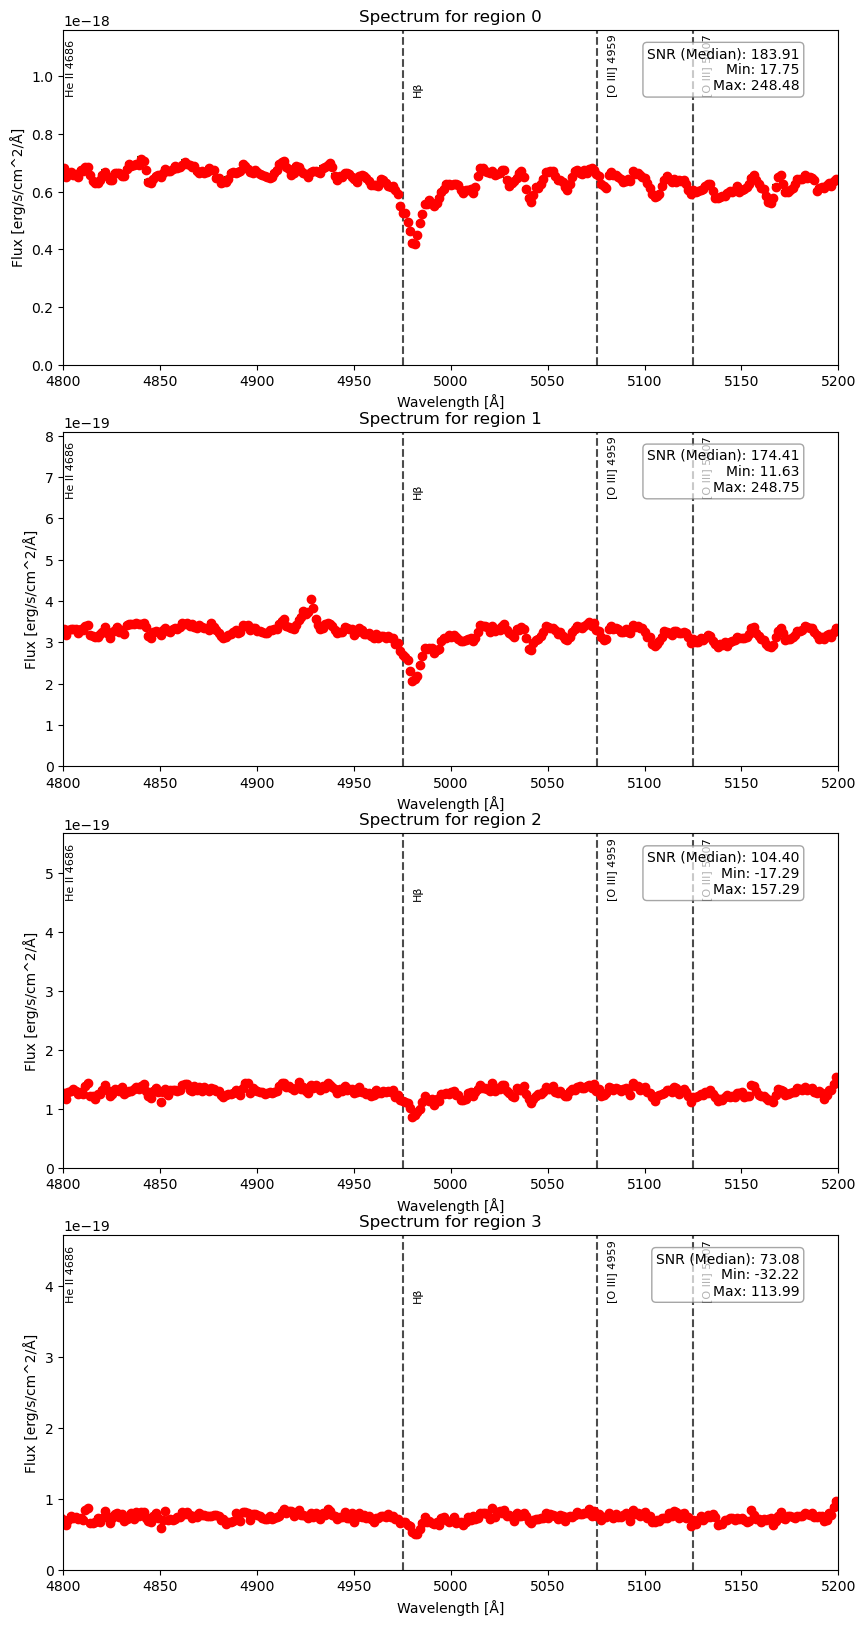

In [143]:
fig,ax= plt.subplots(4,1,figsize=(10,20))
ax = ax.flatten()

for i,mask in enumerate(masks):
    n = len(mask[mask==True])
    # Sum the spectra for the region defined by the mask (sum over the spatial axes)
    spectra_region = np.nansum(cube[:, mask], axis=1) / n
    var_region = np.nansum(var[:, mask], axis=1) / n**2
    ax[i].errorbar(w, spectra_region * cube_units, yerr=np.sqrt(var_region * var_units), fmt='o', color='red', ecolor='green', elinewidth=1.5, capsize=3, capthick=1.5)

    snr = spectra_region / np.sqrt(var_region)
    #ax[i].plot(w,snr)
    snr_median = np.nanmedian(snr)
    snr_min = np.nanmin(snr)
    snr_max = np.nanmax(snr)
    
    # Add text to the upper right of the plot
    ax[i].text(
        0.95, 0.95, 
        f"SNR (Median): {snr_median:.2f}\nMin: {snr_min:.2f}\nMax: {snr_max:.2f}",
        ha='right', va='top', 
        transform=ax[i].transAxes, 
        fontsize=10, bbox=dict(boxstyle='round,pad=0.3', edgecolor='gray', facecolor='white', alpha=0.7)
    )

    for name, wavelength in redshifted_lines.items():
        ax[i].axvline(wavelength, color="black", linestyle="dashed", alpha=0.7)

        y_max = ax[i].get_ylim()[1]
        ax[i].text(wavelength + 5, y_max * 1.2, name, 
                   rotation=90, verticalalignment="bottom", fontsize=8, zorder=1, clip_on=True)

    ax[i].set_ylim(0,1.5*y_max)
    #ax[i].set_xlim(6600,7800)
    ax[i].set_xlim(4800,5200)
    ax[i].set_xlabel("Wavelength [Å]")
    ax[i].set_ylabel("Flux [erg/s/cm^2/Å]")
    ax[i].set_title(f"Spectrum for region {i:.0f}")

plt.show()


# HST

In [2]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np
import matplotlib.pyplot as plt


with fits.open("DATA/NGC_4848/F600LP_drc.fits") as hdul:
    hdul.info()  # Shows a summary of the FITS file

    print('\n')
    header = hdul[1].header
    for card in header.cards:
        print(f"{card[0]:<8} = {card[1]} / {card[2]}")  

    image_600LP = hdul[1].data

print("\n")

# Open the FITS file
with fits.open("DATA/NGC_4848/F350LP_drc.fits") as hdul:
    # Print information about the file structure
    hdul.info()
    
    print('\n')
    header = hdul[1].header
    for card in header.cards:
        print(f"{card[0]:<8} = {card[1]} / {card[2]}")  
    
    # Read the table from HDU 4 (HDRTAB)
    #hdrtab_data = Table(hdul[4].data)  # Convert to Astropy Table for easy manipulation

    image_350LP = hdul[1].data



# zero points

conversion_factor_600LP = 8.737086975e-20 # from e/s to erg/s/cm^2/angstrom
pivot_wavelength_600LP = 7460.8884 
bandwidth_600LP = 941.496155

conversion_factor_350LP = 5.1933534e-20 # from e/s to erg/s/cm^2/angstrom
pivot_wavelength_350LP = 5862.50925
bandwidth_350LP = 1486.5384

wcs = WCS(header)

# Extract image dimensions
naxis1, naxis2 = header['NAXIS1'], header['NAXIS2']

ra_min, dec_min = wcs.all_pix2world([[0, 0]], 0)[0]
ra_max, dec_max = wcs.all_pix2world([[naxis1, naxis2]], 0)[0]

Filename: DATA/NGC_4848/F600LP_drc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     919   ()      
  1  SCI           1 ImageHDU       100   (6994, 7237)   float32   
  2  WHT           1 ImageHDU        44   (6994, 7237)   float32   
  3  CTX           1 ImageHDU        37   ()      
  4  HDRTAB        1 BinTableHDU    557   8R x 274C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, K, 9A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, K, 8A, 23A, D, D, D, D, K, K, 8A, 23A, 9A, 19A, 4A, K, D, D, D, K, K, K, K, 23A, D, D, D, D, K, K, 4A, 3A, 4A, L, D, D, D, 23A, 1A, K, D, D, D, 4A, 1A, 12A, 12A, 8A, 23A, D, D, 10A, 10A, D, D, D, 4A, 3A, 3A, 4A, 8A, 7A, D, K, D, 6A, 9A, 8A, D, D, 9A, 18A, 3A, K, 6A, 4A, D, 13A, 8A, 4A, 3A, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, L, 1A, 4A, D, 3A, 6A, D, D, D, D, D, 23A, D, D, D, D, D, 1A, K, K, K, K, D, 3A, K, D, 5A, 7A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 13A, 

In [4]:
# Create regions# Create regions
import matplotlib.path as mpath

# Add ellipses
center = (194.523241, 28.242570)  # Center of the galaxy (reference coordinates)
angle = - 64  # Angle of tilt in degrees

x = np.linspace(ra_min,ra_max)
m_semimajor_axis = np.tan(np.radians(angle))
y_semi =  m_semimajor_axis * (x - center[0]) + center[1]

e = np.sqrt(1-(160/450)**2)
width = 0.0015
n = 7

# Generate the coordinate grid
y_coords, x_coords = np.meshgrid(np.linspace(dec_min, dec_max, image_600LP.shape[0]),
                                 np.linspace(ra_min, ra_max, image_600LP.shape[1]),
                                 indexing='ij')
x_p = 194.52 + 0.0046
y_p = m_semimajor_axis * (x_p - center[0]) + center[1]
m_line = -1/m_semimajor_axis
y_line =  m_line * (x - x_p) + y_p

down_mask = (y_coords < m_line * (x_coords - x_p) + y_p)

# Flatten coordinates for easier processing
points = np.vstack((x_coords.ravel(), y_coords.ravel())).T

masks = []

for i in range(1, n):

    mask = np.zeros_like(image_600LP, dtype=bool)
    
    # external ellipse
    a = width * i                # semimajor axis
    b = a * np.sqrt(1-e**2)   

    # Generate ellipse vertices
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_x = a * np.cos(theta)
    ellipse_y = b * np.sin(theta)
    cos_angle, sin_angle = np.cos(np.radians(angle)), np.sin(np.radians(angle))
    x_rot = ellipse_x * cos_angle - ellipse_y * sin_angle
    y_rot = ellipse_x * sin_angle + ellipse_y * cos_angle
    vertices_ext = np.column_stack([x_rot + center[0], y_rot + center[1]])

    # internal ellipse
    a = width * (i-1)                # semimajor axis
    b = a * np.sqrt(1-e**2)   

    # Generate ellipse vertices
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_x = a * np.cos(theta)
    ellipse_y = b * np.sin(theta)
    cos_angle, sin_angle = np.cos(np.radians(angle)), np.sin(np.radians(angle))
    x_rot = ellipse_x * cos_angle - ellipse_y * sin_angle
    y_rot = ellipse_x * sin_angle + ellipse_y * cos_angle
    vertices_int = np.column_stack([x_rot + center[0], y_rot + center[1]])

    # Create paths for the ellipses
    path_ext = mpath.Path(vertices_ext)
    path_int = mpath.Path(vertices_int)

    # Mask points within the external but outside the internal ellipse
    mask_ext = path_ext.contains_points(points).reshape(mask.shape)
    mask_int = path_int.contains_points(points).reshape(mask.shape)
    
    mask |= (mask_ext & ~mask_int & down_mask)
    
    masks.append(mask)

In [5]:
dtheta_pix = abs(header['CD1_1'])

units_600LP = conversion_factor_600LP / (dtheta_pix * 3600 )**2
units_350LP = conversion_factor_350LP / (dtheta_pix  * 3600 )**2

image_600LP_phys = image_600LP * units_600LP
image_350LP_phys = image_350LP * units_350LP

In [ ]:
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 2, figsize=(10, 10))  
ax = ax.flatten()

norm = LogNorm(np.nanquantile(image_600LP_phys[image_600LP_phys>0], 0.01), vmax=np.nanquantile(image_600LP_phys, 0.99))

cmap = plt.cm.magma
cmap.set_bad(color='white')
im0 = ax[0].imshow(image_600LP_phys, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap=cmap, norm=norm)
ax[0].set_title(f"{pivot_wavelength_600LP:.2f} Å, bandwidth = {bandwidth_600LP:.2f} Å")
ax[0].set_xlabel("RA (deg)") 
ax[0].set_ylabel("DEC (deg)")  

norm = LogNorm(np.nanquantile(image_350LP_phys[image_350LP_phys>0], 0.01), vmax=np.nanquantile(image_350LP_phys, 0.99))
cmap = plt.cm.viridis
im1 = ax[1].imshow(image_350LP_phys, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap=cmap, norm=norm)
ax[1].set_title(f"{pivot_wavelength_350LP:.2f} Å, bandwidth = {bandwidth_350LP:.2f} Å")
ax[1].set_xlabel("RA (deg)") 
ax[1].set_ylabel("DEC (deg)")  

cbar0 = fig.colorbar(im0, ax=ax[0], location='bottom', shrink=0.4, pad = 0.1)
cbar1 = fig.colorbar(im1, ax=ax[1], location='bottom', shrink=0.4, pad = 0.1)

cbar0.set_label("Specific Flux (erg/s/cm^2/Å/arcsec^2)")  
cbar1.set_label("Specific Flux (erg/s/cm^2/Å/arcsec^2)")  

# Create ellipses and add them to the plot
for i in range(1, n):
    a = 0.0015 * i                # semimajor axis
    b = a * np.sqrt(1-e**2)   
    
    for k in range(2):
        ellipse = Ellipse(center, a*2, b*2, angle=angle, edgecolor='navy', facecolor='none')
        ax[k].add_patch(ellipse)
        #x_text = center[0] + a * np.cos(np.radians(angle)) - 5
        #y_text = m_semimajor_axis * (x_text - center[0]) + center[1]
        #ax[k].text(x_text,y_text, i, fontsize=15, zorder=1, clip_on=True,c='navy')

ax[0].scatter(center[0], center[1], marker='+', c='red')
ax[1].scatter(center[0], center[1], marker='+', c='red')
ax[0].plot(x,y_semi,linestyle=':',c='red')
ax[1].plot(x,y_semi,linestyle=':',c='red')
ax[0].plot(x,y_line,linestyle=':',c='red')
ax[1].plot(x,y_line,linestyle=':',c='red')

#ax[0].imshow(masks[2], extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', interpolation='none', alpha=0.4) #cmap=cmaps[i-1]
#ax[1].imshow(masks[2], extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', interpolation='none', alpha=0.4) #cmap=cmaps[i-1]

for k in range(2):
    #ax[k].set_xlim(ra_min,ra_max)
    #ax[k].set_ylim(dec_min,dec_max)
    ax[k].set_xlim(194.535,194.51)
    ax[k].set_ylim(28.23,28.265)
    #ax[k].grid()


# Adjusting layout to make it fit better
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the tight_layout to leave space for colorbars
plt.show()

# GALEX

NOTE

Coma mosaic updated by MS on Jan. 12, 2025
(can convert to flux densities; no skybg removed, which is very smooth and do not effect photometry of compact sources)


In [3]:
from astropy.io import fits
import numpy as np

# Near UV

with fits.open("DATA/Coma_coadd-int_nuv.fits") as hdul:
    hdul.info()  # Shows a summary of the FITS file

    print('\n')
    header = hdul[0].header
    for card in header.cards:
        print(f"{card[0]:<8} = {card[1]} / {card[2]}")  

    image_nuv = hdul[0].data

# Far UV

with fits.open("DATA/Coma_coadd-int_fuv.fits") as hdul:
    #hdul.info()  # Shows a summary of the FITS file
    image_fuv = hdul[0].data


Filename: DATA/Coma_coadd-int_nuv.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      47   (10750, 9900)   float32   


SIMPLE   = True / file does conform to FITS standard
BITPIX   = -32 / number of bits per data pixel
NAXIS    = 2 / number of data axes
NAXIS1   = 10750 / length of data axis 1
NAXIS2   = 9900 / length of data axis 2
EXTEND   = True / FITS dataset may contain extensions
COMMENT  =   FITS (Flexible Image Transport System) format is defined in 'Astronomy / 
COMMENT  =   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H / 
EQUINOX  = 2000.0 / Mean equinox
RADESYS  = ICRS / Astrometric system
CTYPE1   = RA---TAN / WCS projection type for this axis
CUNIT1   = deg / Axis unit
CRVAL1   = 195.0540528935 / World coordinate on this axis
CRPIX1   = 5375.5 / Reference pixel on this axis
CD1_1    = -0.000416666676756 / Linear projection matrix
CD1_2    = 0.0 / Linear projection matrix
CTYPE2   = DEC--TAN / WCS 

In [4]:
from astropy.wcs import WCS

# The WCS (World Coordinate System) transformation used in FITS files is not just a simple linear transformation.
# It typically involves a gnomonic (tangential) projection combined with a linear transformation matrix. 
# Intermediate coordinates in degrees applying the linear transformation defined by CD_i_j
# Then converting to ra and dec with the tangential projection formula

# . Why Use WCS Instead of a Simple Linear Equation?
# Corrects for distortion: The TAN projection accounts for sky curvature.
# Handles rotation: The CD matrix allows for rotated images.
# More accurate for large images: Your 10750 × 9900 pixel image covers a large sky area, so a simple linear transformation would introduce errors.


wcs_dict = {
    'CTYPE1': 'RA---TAN', 'CUNIT1': 'deg', 'CRVAL1': 195.0540528935, 
    'CRPIX1': 5375.5, 'CD1_1': -0.000416666676756, 'CD1_2': 0.0,
    'CTYPE2': 'DEC--TAN', 'CUNIT2': 'deg', 'CRVAL2': 27.86143255741, 
    'CRPIX2': 4950.5, 'CD2_1': 0.0, 'CD2_2': 0.000416666676756
}

wcs = WCS(wcs_dict)


In [9]:

ra_min_cut = 194.53223072835175  
ra_max_cut = 194.51394223048234

dec_min_cut = 28.232401597627494
dec_max_cut = 28.25434599860988

x_min_cut,y_min_cut = wcs.all_world2pix([[ra_min_cut,dec_min_cut]], 0)[0]
x_max_cut,y_max_cut = wcs.all_world2pix([[ra_max_cut,dec_max_cut]], 0)[0]

#print(x_min_cut,x_max_cut)
#print(y_min_cut,y_max_cut)

image_nuv_cut = image_nuv[int(y_min_cut):int(y_max_cut),int(x_min_cut):int(x_max_cut)]
image_fuv_cut = image_fuv[int(y_min_cut):int(y_max_cut),int(x_min_cut):int(x_max_cut)]


In [20]:

Wave_pivot_fuv = 1524 #uvit website
#AG = args.ebv*MW_extinction(Wave_pivot)  #8.24

ZP_fuv = 18.82
ZP_err_fuv = 0.05

C = ZP_fuv 
conversion_factor_fuv = 10**-C

units_fuv = conversion_factor_fuv / (0.000416666676756 * 3600)**2

Wave_pivot_nuv = 2297 #uvit website
#AG = args.ebv*MW_extinction(Wave_pivot)  #8.24

ZP_nuv = 20.08
ZP_err_nuv = 0.05

C = ZP_nuv 
conversion_factor_nuv = 10**-C

units_nuv = conversion_factor_nuv / (0.000416666676756 * 3600)**2

image_nuv_phys = image_nuv_cut * units_nuv
image_fuv_phys = image_fuv_cut * units_fuv


In [63]:
# Create regions

import matplotlib.path as mpath

# Ellipses
center = (194.523241, 28.242570)  # Center of the galaxy (reference coordinates)
angle = - 64                      # Angle of tilt in degrees

x = np.linspace(ra_min_cut,ra_max_cut)
m_semimajor_axis = np.tan(np.radians(angle))
y_semi =  m_semimajor_axis * (x - center[0]) + center[1]

e = np.sqrt(1-(160/450)**2)
width = 0.0015
n = 7

# Generate the coordinate grid
y_coords, x_coords = np.meshgrid(np.linspace(dec_min_cut, dec_max_cut, image_nuv_cut.shape[0]),
                                 np.linspace(ra_min_cut, ra_max_cut, image_nuv_cut.shape[1]),
                                 indexing='ij')
x_p = 194.52 + 0.0046
y_p = m_semimajor_axis * (x_p - center[0]) + center[1]
m_line = -1/m_semimajor_axis
y_line =  m_line * (x - x_p) + y_p

down_mask = (y_coords < m_line * (x_coords - x_p) + y_p)

points = np.vstack((x_coords.ravel(), y_coords.ravel())).T

masks = []

for i in range(1, n):

    mask = np.zeros_like(image_nuv_cut, dtype=bool)
    
    # external ellipse
    a = width * i                # semimajor axis
    b = a * np.sqrt(1-e**2)   

    # Generate ellipse vertices
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_x = a * np.cos(theta)
    ellipse_y = b * np.sin(theta)
    cos_angle, sin_angle = np.cos(np.radians(angle)), np.sin(np.radians(angle))
    x_rot = ellipse_x * cos_angle - ellipse_y * sin_angle
    y_rot = ellipse_x * sin_angle + ellipse_y * cos_angle
    vertices_ext = np.column_stack([x_rot + center[0], y_rot + center[1]])

    # internal ellipse
    a = width * (i-1)                # semimajor axis
    b = a * np.sqrt(1-e**2)   

    # Generate ellipse vertices
    theta = np.linspace(0, 2 * np.pi, 100)
    ellipse_x = a * np.cos(theta)
    ellipse_y = b * np.sin(theta)
    cos_angle, sin_angle = np.cos(np.radians(angle)), np.sin(np.radians(angle))
    x_rot = ellipse_x * cos_angle - ellipse_y * sin_angle
    y_rot = ellipse_x * sin_angle + ellipse_y * cos_angle
    vertices_int = np.column_stack([x_rot + center[0], y_rot + center[1]])

    # Create paths for the ellipses
    path_ext = mpath.Path(vertices_ext)
    path_int = mpath.Path(vertices_int)

    # Mask points within the external but outside the internal ellipse
    mask_ext = path_ext.contains_points(points).reshape(mask.shape)
    mask_int = path_int.contains_points(points).reshape(mask.shape)
    
    mask |= (mask_ext & ~mask_int & down_mask)

    if len(mask[mask==True])>0:
        masks.append(mask)


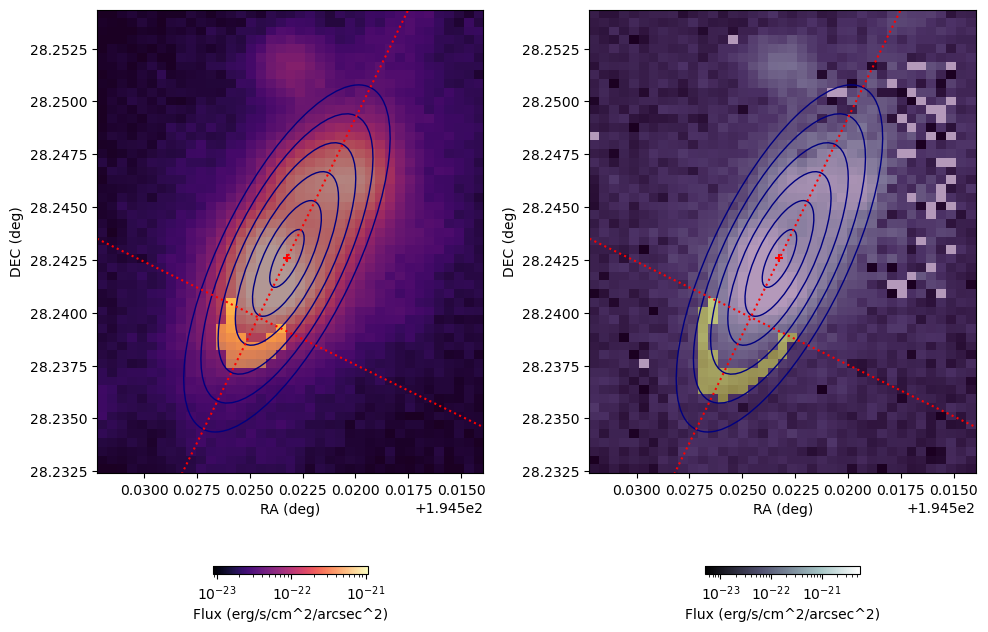

In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 2, figsize=(10, 10))  # Adjust the size for better appearance
ax = ax.flatten()


norm = LogNorm(np.nanquantile(image_nuv_phys[image_nuv_phys>0], 0.01), vmax=np.nanquantile(image_nuv_phys, 0.99))

# nuv
im0 = ax[0].imshow(image_nuv_phys, origin='lower', extent=[ra_min_cut, ra_max_cut, dec_min_cut, dec_max_cut], cmap='magma', norm=norm) 
ax[0].set_xlabel("RA (deg)")  
ax[0].set_ylabel("DEC (deg)")  

# fuv
norm = LogNorm(np.nanquantile(image_fuv_phys[image_fuv_phys>0], 0.01), vmax=np.nanquantile(image_fuv_phys, 0.99))
im1 = ax[1].imshow(image_fuv_phys, origin='lower', extent=[ra_min_cut, ra_max_cut, dec_min_cut, dec_max_cut], cmap='bone', norm=norm)
ax[1].set_xlabel("RA (deg)")  
ax[1].set_ylabel("DEC (deg)")  

cbar0 = fig.colorbar(im0, ax=ax[0], location='bottom', shrink=0.4, pad = 0.1)
cbar1 = fig.colorbar(im1, ax=ax[1], location='bottom', shrink=0.4, pad = 0.1)

cbar0.set_label("Flux (erg/s/cm^2/arcsec^2)")  
cbar1.set_label("Flux (erg/s/cm^2/arcsec^2)")  

######

# Create ellipses and add them to the plot
for i in range(1, n):
    a = width * i                # semimajor axis
    b = a * np.sqrt(1-e**2)   
    
    for k in range(2):
        ellipse = Ellipse(center, a*2, b*2, angle=angle, edgecolor='navy', facecolor='none')
        ax[k].add_patch(ellipse)
        #x_text = center[0] + a * np.cos(np.radians(angle)) - 5
        #y_text = m_semimajor_axis * (x_text - center[0]) + center[1]
        #ax[k].text(x_text,y_text, i, fontsize=15, zorder=1, clip_on=True,c='navy')


ax[0].scatter(center[0], center[1], marker='+', c='red')
ax[1].scatter(center[0], center[1], marker='+', c='red')
ax[0].plot(x,y_semi,linestyle=':',c='red')
ax[1].plot(x,y_semi,linestyle=':',c='red')
ax[0].plot(x,y_line,linestyle=':',c='red')
ax[1].plot(x,y_line,linestyle=':',c='red')

ax[0].imshow(masks[3], extent=[ra_min_cut, ra_max_cut, dec_min_cut, dec_max_cut], origin='lower', interpolation='none', alpha=0.4) #cmap=cmaps[i-1]
ax[1].imshow(masks[4], extent=[ra_min_cut, ra_max_cut, dec_min_cut, dec_max_cut], origin='lower', interpolation='none', alpha=0.4) #cmap=cmaps[i-1]

for k in range(2):
    ax[k].set_xlim(ra_min_cut,ra_max_cut)
    ax[k].set_ylim(dec_min_cut,dec_max_cut)
    #ax[k].set_xlim(194.5+0.03,194.5+0.022)
    #ax[k].set_ylim(28.235,28.243)
    #ax[k].grid()


# Adjusting layout to make it fit better
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the tight_layout to leave space for colorbars
plt.show()

plt.show()



In [23]:
for i,mask in enumerate(masks[2:]):
    n = len(mask[mask==True])
    print(n)
    # Sum the spectra for the region defined by the mask (sum over the spatial axes)
    nuv_phot_point_region = np.nansum(image_nuv_cut[mask]) / n
    print(nuv_phot_point_region)
    fuv_phot_point_region = np.nansum(image_fuv_cut[mask]) / n
    print(fuv_phot_point_region)
    #var_region = np.nansum(var[:, mask], axis=1) / n**2
    #ax[i].errorbar(w, spectra_region * cube_units, yerr=np.sqrt(var_region * var_units), fmt='o', color='red', ecolor='green', elinewidth=1.5, capsize=3, capthick=1.5)


10
0.10873997211456299
0.021173225343227388
27
0.045042324949193885
0.00694090845408263
38
0.020266884251644735
0.0022220895870735773
51
0.011390176473879347
0.0010231874298815633


# HST

In [5]:
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np


with fits.open("DATA/NGC_4848/F600LP_drc.fits") as hdul:
    hdul.info()  # Shows a summary of the FITS file

    print('\n')
    header = hdul[1].header
    for card in header.cards:
        print(f"{card[0]:<8} = {card[1]} / {card[2]}")  

    image_600LP = hdul[1].data

print("\n")

# Open the FITS file
with fits.open("DATA/NGC_4848/F350LP_drc.fits") as hdul:
    # Print information about the file structure
    hdul.info()
    
    print('\n')
    header = hdul[1].header
    for card in header.cards:
        print(f"{card[0]:<8} = {card[1]} / {card[2]}")  
    
    # Read the table from HDU 4 (HDRTAB)
    #hdrtab_data = Table(hdul[4].data)  # Convert to Astropy Table for easy manipulation

    image_350LP = hdul[1].data




Filename: DATA/NGC_4848/F600LP_drc.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     919   ()      
  1  SCI           1 ImageHDU       100   (6994, 7237)   float32   
  2  WHT           1 ImageHDU        44   (6994, 7237)   float32   
  3  CTX           1 ImageHDU        37   ()      
  4  HDRTAB        1 BinTableHDU    557   8R x 274C   [9A, 3A, K, D, D, D, D, D, D, D, D, D, D, D, D, K, 9A, 9A, 7A, 18A, 4A, D, D, D, D, 3A, D, D, D, D, D, D, D, D, D, D, D, D, K, K, 8A, 23A, D, D, D, D, K, K, 8A, 23A, 9A, 19A, 4A, K, D, D, D, K, K, K, K, 23A, D, D, D, D, K, K, 4A, 3A, 4A, L, D, D, D, 23A, 1A, K, D, D, D, 4A, 1A, 12A, 12A, 8A, 23A, D, D, 10A, 10A, D, D, D, 4A, 3A, 3A, 4A, 8A, 7A, D, K, D, 6A, 9A, 8A, D, D, 9A, 18A, 3A, K, 6A, 4A, D, 13A, 8A, 4A, 3A, D, D, D, 3A, 1A, D, 23A, D, D, D, 3A, L, 1A, 4A, D, 3A, 6A, D, D, D, D, D, 23A, D, D, D, D, D, 1A, K, K, K, K, D, 3A, K, D, 5A, 7A, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, 13A, 

In [8]:
units_600LP = conversion_factor_600LP / ( 8.3333333333333e-06 * 3600 )**2
units_350LP = conversion_factor_350LP / ( 8.3333333333333e-06 * 3600 )**2

image_600LP_phys = image_600LP * units_600LP
image_350LP_phys = image_350LP * units_350LP

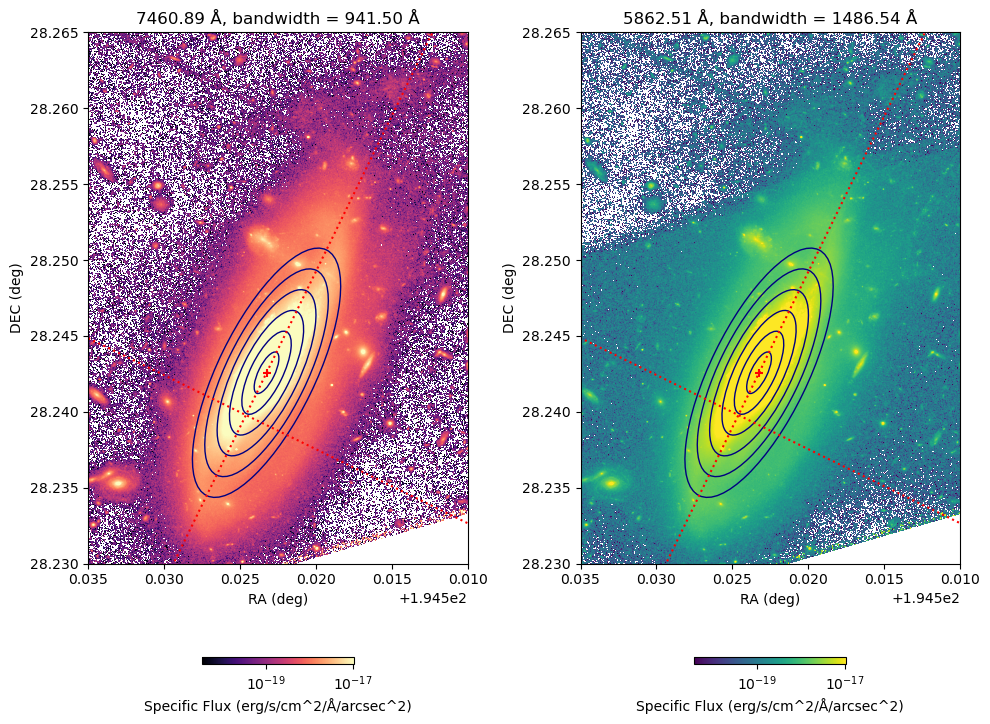

In [9]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

fig, ax = plt.subplots(1, 2, figsize=(10, 10))  
ax = ax.flatten()

norm = LogNorm(np.nanquantile(image_600LP_phys[image_600LP_phys>0], 0.01), vmax=np.nanquantile(image_600LP_phys, 0.99))

cmap = plt.cm.magma
cmap.set_bad(color='white')
im0 = ax[0].imshow(image_600LP_phys, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap=cmap, norm=norm)
ax[0].set_title(f"{pivot_wavelength_600LP:.2f} Å, bandwidth = {bandwidth_600LP:.2f} Å")
ax[0].set_xlabel("RA (deg)") 
ax[0].set_ylabel("DEC (deg)")  

norm = LogNorm(np.nanquantile(image_350LP_phys[image_350LP_phys>0], 0.01), vmax=np.nanquantile(image_350LP_phys, 0.99))
cmap = plt.cm.viridis
im1 = ax[1].imshow(image_350LP_phys, extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', cmap=cmap, norm=norm)
ax[1].set_title(f"{pivot_wavelength_350LP:.2f} Å, bandwidth = {bandwidth_350LP:.2f} Å")
ax[1].set_xlabel("RA (deg)") 
ax[1].set_ylabel("DEC (deg)")  

cbar0 = fig.colorbar(im0, ax=ax[0], location='bottom', shrink=0.4, pad = 0.1)
cbar1 = fig.colorbar(im1, ax=ax[1], location='bottom', shrink=0.4, pad = 0.1)

cbar0.set_label("Specific Flux (erg/s/cm^2/Å/arcsec^2)")  
cbar1.set_label("Specific Flux (erg/s/cm^2/Å/arcsec^2)")  

# Create ellipses and add them to the plot
for i in range(1, n):
    a = 0.0015 * i                # semimajor axis
    b = a * np.sqrt(1-e**2)   
    
    for k in range(2):
        ellipse = Ellipse(center, a*2, b*2, angle=angle, edgecolor='navy', facecolor='none')
        ax[k].add_patch(ellipse)
        #x_text = center[0] + a * np.cos(np.radians(angle)) - 5
        #y_text = m_semimajor_axis * (x_text - center[0]) + center[1]
        #ax[k].text(x_text,y_text, i, fontsize=15, zorder=1, clip_on=True,c='navy')

ax[0].scatter(center[0], center[1], marker='+', c='red')
ax[1].scatter(center[0], center[1], marker='+', c='red')
ax[0].plot(x,y_semi,linestyle=':',c='red')
ax[1].plot(x,y_semi,linestyle=':',c='red')
ax[0].plot(x,y_line,linestyle=':',c='red')
ax[1].plot(x,y_line,linestyle=':',c='red')

#ax[0].imshow(masks[2], extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', interpolation='none', alpha=0.4) #cmap=cmaps[i-1]
#ax[1].imshow(masks[2], extent=[ra_min, ra_max, dec_min, dec_max], origin='lower', interpolation='none', alpha=0.4) #cmap=cmaps[i-1]

for k in range(2):
    #ax[k].set_xlim(ra_min,ra_max)
    #ax[k].set_ylim(dec_min,dec_max)
    ax[k].set_xlim(194.535,194.51)
    ax[k].set_ylim(28.23,28.265)
    #ax[k].grid()


# Adjusting layout to make it fit better
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the tight_layout to leave space for colorbars
plt.show()

['SPITZER_I2_62071040_0000_1_E12358009_maic.fits', 'SPITZER_I3_3859968_0000_6_E8757229_maic.fits', 'SPITZER_I1_62071040_0000_1_E12358018_maic.fits', 'SPITZER_I2_35345920_0000_3_E11727942_maic.fits', 'SPITZER_I1_35345920_0000_3_E11722218_maic.fits']
Processing: SPITZER_I2_35345920_0000_3_E11727942_maic.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 194.518647  28.247464  
CRPIX : 1191.5  505.0  
CD1_1 CD1_2  : -6.18581916591746e-05  -0.000154762569808261  
CD2_1 CD2_2  : -0.000154762569808261  6.18581916591746e-05  
NAXIS : 2382  1009


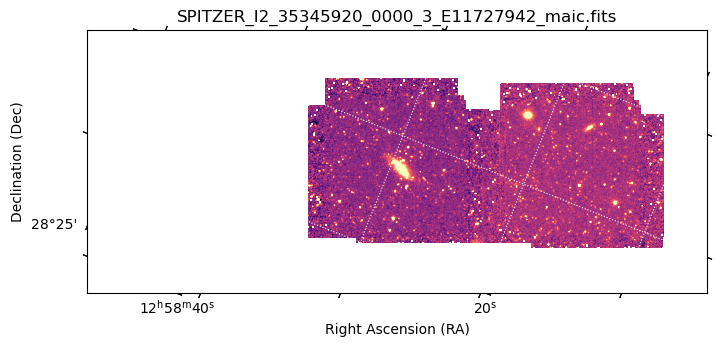

Processing: SPITZER_I1_35345920_0000_3_E11722218_maic.fits
WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 194.518647  28.247464  
CRPIX : 1191.5  505.0  
CD1_1 CD1_2  : -6.18581916591746e-05  -0.000154762569808261  
CD2_1 CD2_2  : -0.000154762569808261  6.18581916591746e-05  
NAXIS : 2382  1009


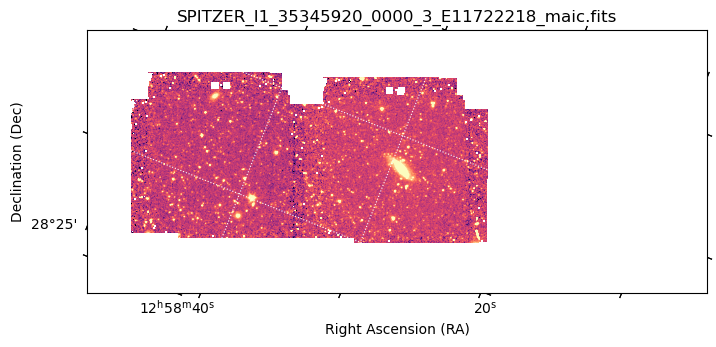

In [97]:
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np

# Set the folder containing the FITS files
fits_folder = "DATA/NGC_4848/spitzer"  # Change this to your actual folder path

# Get a list of all FITS files ending with ".aic.fits"
fits_files = [f for f in os.listdir(fits_folder) if f.endswith("maic.fits")]
print(fits_files)
# Check if there are any matching FITS files
if not fits_files:
    print("No '.maic.fits' files found in the folder.")
else:
    # Loop through and process each FITS file
    for fits_file in fits_files[3:]:
        file_path = os.path.join(fits_folder, fits_file)
        print(f"Processing: {fits_file}")

        # Open the FITS file
        with fits.open(file_path) as hdul:
            image_data = hdul[0].data  # Extract image data from the primary extension
            wcs = WCS(hdul[0].header)  # Get WCS from the header

            print(wcs)
        # Plot the image with WCS projection
        fig, ax = plt.subplots(figsize=(8, 6), subplot_kw={'projection': wcs})
        norm = LogNorm(np.nanquantile(image_data[image_data>0], 0.01), vmax=np.nanquantile(image_data, 0.99))
        ax.imshow(image_data, cmap='magma', norm=norm) #rigin='lower



        # Add labels and grid
        ax.set_xlabel("Right Ascension (RA)")
        ax.set_ylabel("Declination (Dec)")
        ax.set_title(f"{fits_file}")
        ax.grid(color='white', ls='dotted')

        # Show the plot
        plt.show()